In [2]:
# Append the path to the src folder to the system path
# To be able to import the modules in the src folder
import sys
sys.path.append('../')

# Environment Variables

environ = 'local'


DATASETS_PATH = '..\\local_storage\\csc_data'



Feature Engineering

In [3]:
from scipy.signal import savgol_filter

import numpy as np


def savitzky_golay_filter(data, window_size=5, polynomial_order=3):
    """Applies a Savitzky-Golay filter to the data."""
    return savgol_filter(data, window_size, polynomial_order)

def differentiate(data, time):
    """Differentiates data with respect to time."""
    return np.gradient(data, time)

def add_steering_velocity(df):
    """Adds a new feature to the dataframe: steering velocity."""
    
    df = df.copy()
    
   #  assert (df['t'].diff() > 0).all(), "Timestamps are not strictly increasing!"

    # df.loc[:, 'steeringVelocity'] = differentiate(df['steeringAngleDeg'], df['t'])
    df['steeringVelocity'] = df['steeringAngleDeg'].diff() / (df['t'].diff() + 1e-8)

    # TODO: Add/explore preprocessing for steering velocity
    # Replace inf/-inf with the maximum/minimum finite values
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_finite = df['steeringVelocity'][np.isfinite(df['steeringVelocity'])].max()
    min_finite = df['steeringVelocity'][np.isfinite(df['steeringVelocity'])].min()
    df['steeringVelocity'] = np.clip(df['steeringVelocity'], min_finite, max_finite)

    # df['steeringVelocity'] = df['steeringVelocity'].rolling(window=5, min_periods=1).mean()
    df.fillna(0, inplace=True)

    # Apply filter to remove noise
    df['steeringVelocity'] = savitzky_golay_filter(df['steeringVelocity'], 5, 2)
    # df['steeringVelocity'] = moving_average(df['steeringVelocity'], 1)

    return df

def add_steering_acceleration(df):
    """Adds a new feature to the dataframe: steering acceleration."""

    df = df.copy()

    # assert (df['t'].diff() > 0).all(), "Timestamps are not strictly increasing!"

    # df.loc[:, 'steeringAcceleration'] = differentiate(df['steeringVelocity'], df['t'])
    df['steeringAcceleration'] = df['steeringVelocity'].diff() / (df['t'].diff() + 1e-8)

    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_finite = df['steeringAcceleration'][np.isfinite(df['steeringAcceleration'])].max()
    min_finite = df['steeringVelocity'][np.isfinite(df['steeringAcceleration'])].min()
    df['steeringAcceleration'] = np.clip(df['steeringAcceleration'], min_finite, max_finite)

    # df['steeringAcceleration'] = df['steeringAcceleration'].rolling(window=5, min_periods=1).mean()
    df.fillna(0, inplace=True)

    # Apply filter to remove noise
    df['steeringAcceleration'] = savitzky_golay_filter(df['steeringAcceleration'], 5, 2)
    # df['steeringVelocity'] = moving_average(df['steeringVelocity'], 1)

    return df

def add_ema(df, feature, window=5):
    """Adds an Exponential Moving Average (EMA) to the dataframe."""
    
    df = df.copy()
    
    df[f'{feature}_ema'] = df[feature].ewm(span=window, adjust=False).mean()
    
    return df



In [4]:
import logging

from data.csc_data import CSCDataset
from data.df_preprocessing import (
  EMAFeatureAdderDP, CompositeDP, LagAdderDP, RollingMeanFeatureAdderDP,
  LowPassFilterDP, FeatureAdderDP, FeatureRemoverDP, MinMaxScalerDP
)
from functions.constants import FEATURES

DATASET_NAME = 'AUDI_Q3_2ND_GEN'
IS_PREDICTION = False



# TODO: These will be part of the training data pipeline in the actual code (not a notebook)
# When deploying the model, we will have access to velocity and acceleration (in CARLA)

# Not using MinMaxScalerDP for now (XGBoost is not sensitive to feature scaling)
train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration
    ]),
    RollingMeanFeatureAdderDP(["steerFiltered"], window=5),
    LagAdderDP("steerFiltered", lag=1),
    LagAdderDP("steerFiltered", lag=2),
    LagAdderDP("steerFiltered", lag=3),
    FeatureRemoverDP(['t']),
    FeatureRemoverDP(['steerFiltered']),
    # MinMaxScalerDP(save_path='./min_max_scaler.pkl')
])

train_preprocessor.save()

label_preprocessor = None


dataset = CSCDataset(DATASET_NAME, 
                     FEATURES,
                     download=True,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)
total_dataset_size, num_csv = dataset.get_csv_metadata()

print(f"Total file size of dataset: {round(total_dataset_size, 3)} MB")
print(f"Number of CSV files in dataset: {num_csv}")

print(f"Number of samples in dataset: {len(dataset)}")



Total file size of dataset: 149.99 MB
Number of CSV files in dataset: 1000
Number of samples in dataset: 1000


In [5]:
from torch.utils.data import DataLoader

# Load all data at once
train_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Extract features and labels
features_list, targets_list = [], []

for batch_idx, (X, y) in enumerate(train_loader):
    # Convert PyTorch tensors to NumPy
    features_list.append(X.numpy())  
    targets_list.append(y.numpy())


# Convert to NumPy arrays
# Shape: (num_samples, num_features)
X_np = np.vstack(features_list)

# Shape: (num_samples,)
y_np = np.hstack(targets_list)   

# Check data shape
print("Features shape:", X_np.shape)
print("Targets shape:", y_np.shape)


Features shape: (1000, 601, 9)
Targets shape: (1000, 601)


XGBoost Model

In [6]:
import xgboost as xgb
import shutil

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(X_np))
X_train, X_test = X_np[:train_size], X_np[train_size:]
y_train, y_test = y_np[:train_size], y_np[train_size:]


# Need to reshape into a 2D array for XGBoost (num_samples, num_features) - flatten the 3D array

num_features = X_np.shape[2]

# Reshape 3D array into 2D array
X_train = X_train.reshape(-1, num_features)
X_test = X_test.reshape(-1, num_features)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Train XGBoost Model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=120,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=True)

xgb_models_dir = 'xgboost_saved_models'

model_name = 'torque_pred_xgb_model'
model_path = f'{xgb_models_dir}\\{model_name}.json'
model.save_model(model_path)

expected_gcp_model_name = "model"
pkl_model_path = f'{xgb_models_dir}\\{expected_gcp_model_name}.pkl' 
shutil.copyfile(model_path, pkl_model_path)



X_train shape: (480800, 9)
X_test shape: (120200, 9)
[0]	validation_0-rmse:0.23059
[1]	validation_0-rmse:0.21980
[2]	validation_0-rmse:0.20957
[3]	validation_0-rmse:0.19986
[4]	validation_0-rmse:0.19071
[5]	validation_0-rmse:0.18199
[6]	validation_0-rmse:0.17369
[7]	validation_0-rmse:0.16585
[8]	validation_0-rmse:0.15845
[9]	validation_0-rmse:0.15141
[10]	validation_0-rmse:0.14476
[11]	validation_0-rmse:0.13846
[12]	validation_0-rmse:0.13249
[13]	validation_0-rmse:0.12687
[14]	validation_0-rmse:0.12156
[15]	validation_0-rmse:0.11656
[16]	validation_0-rmse:0.11183
[17]	validation_0-rmse:0.10743
[18]	validation_0-rmse:0.10321
[19]	validation_0-rmse:0.09924
[20]	validation_0-rmse:0.09548
[21]	validation_0-rmse:0.09196
[22]	validation_0-rmse:0.08865
[23]	validation_0-rmse:0.08554
[24]	validation_0-rmse:0.08262
[25]	validation_0-rmse:0.07988
[26]	validation_0-rmse:0.07748
[27]	validation_0-rmse:0.07507
[28]	validation_0-rmse:0.07282
[29]	validation_0-rmse:0.07070
[30]	validation_0-rmse:0.06

'xgboost_saved_models\\model.pkl'

Upload Model to GCP Bucket

In [7]:
# Upload the model to GCP
from google.cloud import storage

GCP_PROJECT_ID = 'coastal-wares-448023-s7'
GCP_BUCKET_NAME = 'csi5370_bucket'
ML_MODELS_DIR = xgb_models_dir
BLOB_NAME = f'{ML_MODELS_DIR}/{expected_gcp_model_name}.pkl'
GCP_MODEL_DIR = f'gs://{GCP_BUCKET_NAME}/{ML_MODELS_DIR}'


client = storage.Client()
bucket = client.bucket(GCP_BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)

# Upload the model file
blob.upload_from_filename(model_path)
print(f"Model uploaded to: {GCP_MODEL_DIR}/{expected_gcp_model_name}.pkl")



Model uploaded to: gs://csi5370_bucket/xgboost_saved_models/model.pkl


Register in Vertex AI endpoint

In [10]:
from google.cloud import aiplatform

aiplatform.init(project=GCP_PROJECT_ID, location="us-central1")

# Register model in Vertex AI Model Registry
model = aiplatform.Model.upload(
    display_name=model_name,
    artifact_uri=GCP_MODEL_DIR,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-7:latest",
    # local_model=model_path
)

print(f"Model registered: {model.resource_name}")

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

(120200,)
(120200,)
Mean Squared Error: 0.00167661526646781


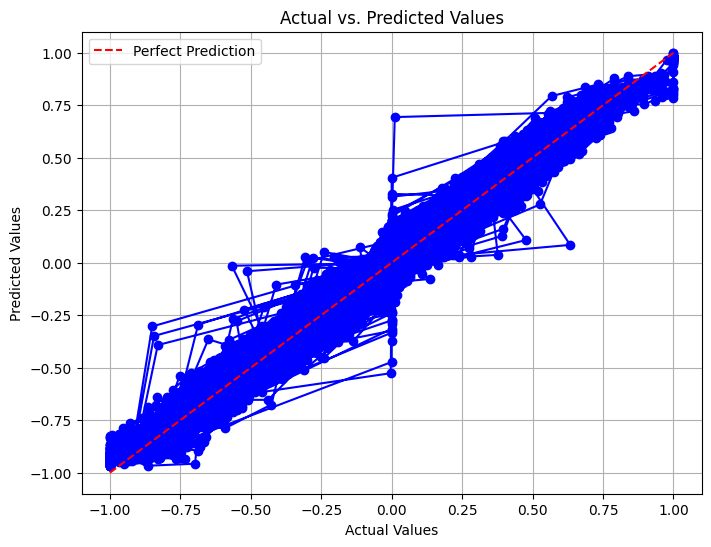

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load Model
model = xgb.XGBRegressor()

model_name = 'torque_pred_xgboost_model'
is_latest = True

if is_latest:
    # Load the latest model
    model.load_model(f'xgboost_saved_models\\{model_name}_latest.json')


# Reshape 3D array into 2D array (1300)
y_test = y_test.reshape(-1, 1).squeeze()
print(y_test.shape)

# Evaluate Model
y_pred = model.predict(X_test)

print(y_pred.shape)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot predictions vs. actual values, in a linear plot

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.plot(y_test, y_pred, marker='o', linestyle='-', color='blue')

# Add a diagonal line for perfect predictions
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='Perfect Prediction')

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a legend
plt.legend()

plt.grid(True)
plt.show()

In [7]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

print("Confusion Matrix:")
print(cm)


# # Create the plot
# plt.figure(figsize=(8, 6))  # Adjust figure size as needed
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# # Add labels and title
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")

# plt.show()




Confusion Matrix:
[[117496    248]
 [   408   2048]]


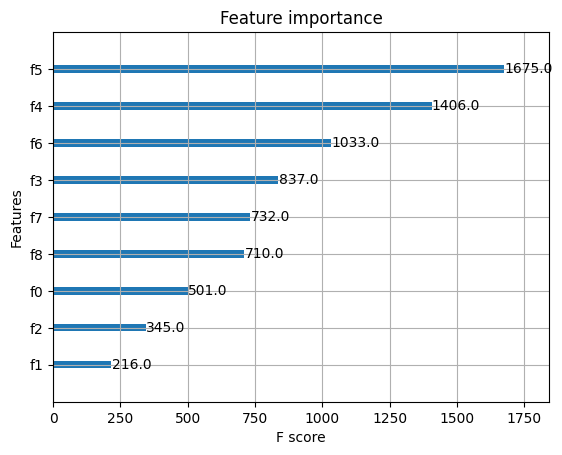

In [8]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

Predicting CSV file ID: 1250
Skipped 1250 files
(611, 9)
(611, 1)
Prediction time: 0.0010001659393310547 seconds
(611,)


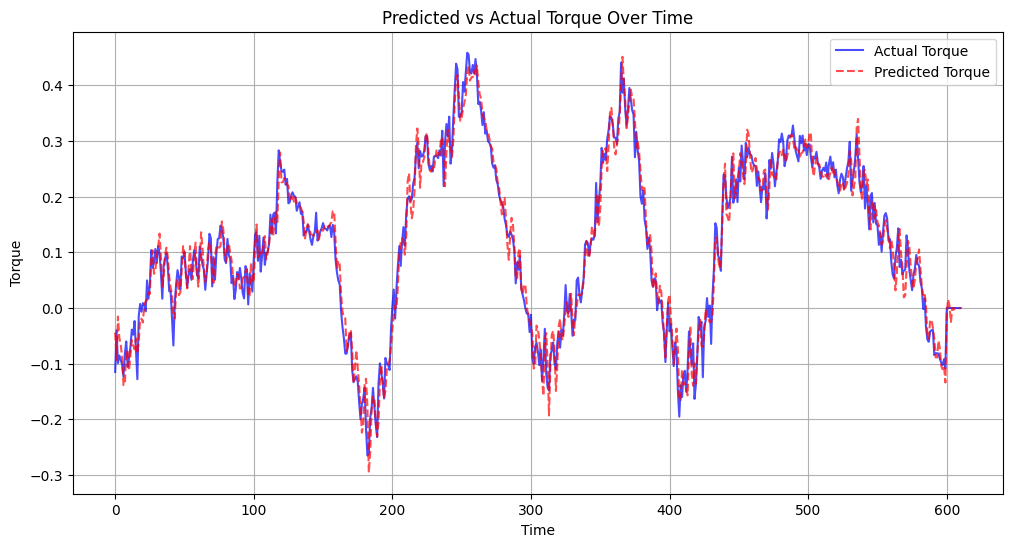

In [9]:
import time
import random

DATASET_NAME = 'LEXUS_RX_2020'
IS_PREDICTION = True


# TODO: These will be part of the training data pipeline in the actual code (not a notebook)
# When deploying the model, we will have access to velocity and acceleration (in CARLA)

# train_preprocessor = CompositeDP([
#     FeatureAdderDP([
#         add_steering_velocity,
#         add_steering_acceleration
#     ]),
#     LagAdderDP("steeringAngleDeg", 5),
#     LagAdderDP("steeringAngleDeg", 7),
#     LagAdderDP("steeringAngleDeg", 9),
#     RollingMeanFeatureAdderDP(["steeringAngleDeg"], 5),
#     FeatureRemoverDP(['t']),
#     MinMaxScalerDP(save_path='./min_max_scaler.pkl')
# ])

# Not using MinMaxScalerDP for now (XGBoost is not sensitive to feature scaling)
train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration
    ]),
    RollingMeanFeatureAdderDP(["steerFiltered"], window=5),
    LagAdderDP("steerFiltered", lag=1),
    LagAdderDP("steerFiltered", lag=2),
    LagAdderDP("steerFiltered", lag=3),
    FeatureRemoverDP(['t']),
    FeatureRemoverDP(['steerFiltered']),
    # MinMaxScalerDP(save_path='./min_max_scaler.pkl')
])

label_preprocessor = None


test_dataset = CSCDataset(DATASET_NAME, 
                     FEATURES,
                     download=True,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)


# Load one csv file at a time
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Extract features and labels
features_list, targets_list = [], []

skipped = 0

# Randomly select csv file to predict
csv_id = random.randint(0, len(test_dataset) - 1)
print(f"Predicting CSV file ID: {csv_id}")


X = None
y = None


for batch_idx, (X, y) in enumerate(test_loader):

    if not batch_idx == csv_id:
        skipped += 1
        continue

    print(f"Skipped {skipped} files")

    # Convert PyTorch tensors to NumPy
    X = X.numpy()  
    y = y.numpy()
    break


num_features = X.shape[2]



# Plotting
# Convert to NumPy arrays
# Shape: (num_samples, num_features)
X = X.reshape(-1, num_features)
actual_torque = y.reshape(-1, 1)

print(X.shape)
print(actual_torque.shape)


time_start = time.time()
predicted_torque = model.predict(X)
time_end = time.time()

print(f"Prediction time: {time_end - time_start} seconds")

print(predicted_torque.shape)


# Plot predicted vs actual torque
plt.figure(figsize=(12, 6))
plt.plot(actual_torque, label="Actual Torque", linestyle="-", color="blue", alpha=0.7)
plt.plot(predicted_torque, label="Predicted Torque", linestyle="--", color="red", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Torque")
plt.title("Predicted vs Actual Torque Over Time")
plt.legend()
plt.grid(True)
plt.show()


FeedForward Neural Network (Skipping for Timing)

In [35]:
import os
import torch
import argparse
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import DataLoader
from functions.main import (
    load_CSC_dataset,
    split_dataset,
    prepare_data_loaders,
    initialize_model,
    train_model,
    evaluate_model
)
from functions.constants import (
  FEATURES,
)
from functions.constants import FEATURES, BATCH_SIZE, NUM_FEATURES
from utils import safe_save_or_show_plot, save_preprocessor
from pathlib import Path


DATASET_NAME = 'AUDI_Q3_2ND_GEN'
IS_PREDICTION = False


train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration
    ]),
    RollingMeanFeatureAdderDP(["steerFiltered"], window=5),
    LagAdderDP("steerFiltered", lag=1),
    LagAdderDP("steerFiltered", lag=2),
    LagAdderDP("steerFiltered", lag=3),
    FeatureRemoverDP(['t']),
    FeatureRemoverDP(['steerFiltered']),
    # MinMaxScalerDP(save_path='./min_max_scaler.pkl')
])

train_preprocessor.save()
label_preprocessor = None

nn_dataset = CSCDataset(DATASET_NAME, 
                     FEATURES,
                     download=True,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)
total_dataset_size, num_csv = dataset.get_csv_metadata()

print(f"Total file size of dataset: {round(total_dataset_size, 3)} MB")
print(f"Number of CSV files in dataset: {num_csv}")
print(f"Number of samples in dataset: {len(nn_dataset)}")


Total file size of dataset: 149.99 MB
Number of CSV files in dataset: 1000
Number of samples in dataset: 1000


In [37]:
# Set up the device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


train_dataset, val_dataset = split_dataset(nn_dataset)
train_loader, val_loader = prepare_data_loaders(train_dataset, val_dataset)

# Initialize and train the model
model = initialize_model(9, device)

model, train_losses, val_losses, saved_model = train_model(model, 
                                                           train_loader, 
                                                           val_loader, 
                                                           device, 
                                                           DATASET_NAME)

# Evaluate the model on the validation set
val_loss, predictions, actuals = evaluate_model(model, val_loader, device)
print(f"Validation loss: {val_loss}")


Using device: cuda
Train dataset size: 800
Validation dataset size: 200
Using device: cuda


KeyboardInterrupt: 

Validation Loss

In [ ]:

def plot_and_save_loss(train_losses, val_losses, model_name):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()

    # Save the plot Train_Val_Loss_Graphs
    save_fig_path = os.path.join(os.getcwd(), f'saved_models/{model_name}', f'train_loss_graph.png')
    safe_save_or_show_plot(plt, save_fig_path)
    

model_name = os.path.basename(saved_model).split('.')[0]
plot_and_save_loss(train_losses, val_losses, model_name)

Hyperparameter Tuning (TODO: Run, it takes a while...)

(1, 611, 7)
(1, 611)
(611, 7)
(611, 1)
(611,)


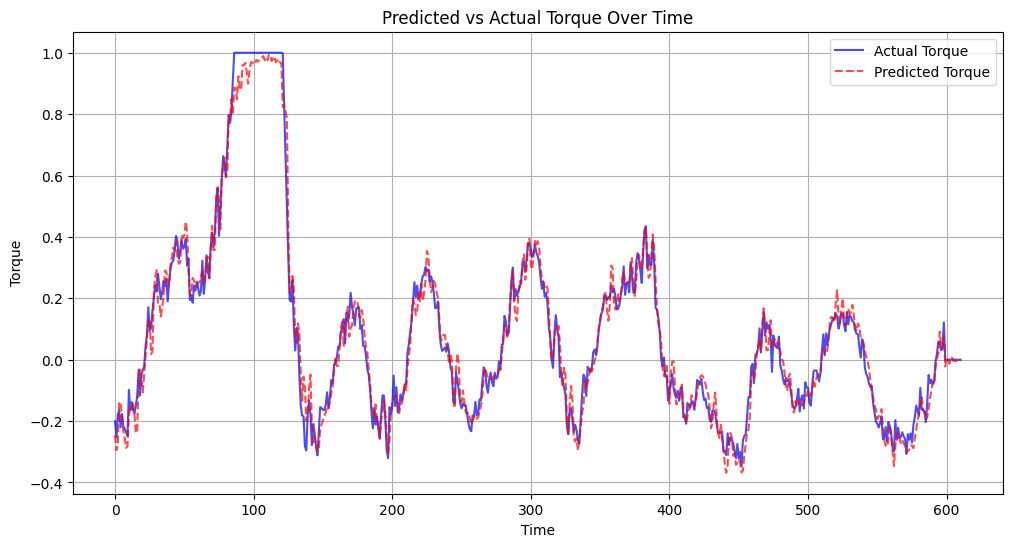

In [ ]:
import optuna

def objective(trial):
    param = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }

    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
print(study.best_params)


Previous Predictions (Without torque rolling mean and torque lags):

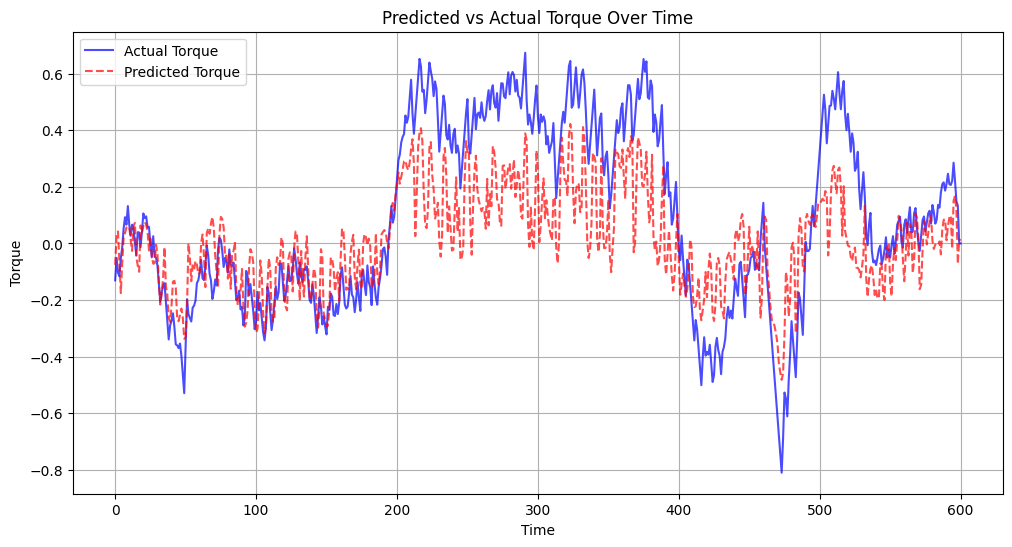